In [1]:
import torch
from model.model_vae_3no_sig_1 import CVAE, cvae_loss_masked ## 따로 sigmoid 진행하지 않았음
from vae_earlystopping import EarlyStopping
import numpy as np
import joblib
import pandas as pd

In [2]:
train_loader = torch.load('torch/train_loader.pt')
val_loader = torch.load('torch/val_loader.pt')
test_loader = torch.load('torch/test_loader.pt')

C:\Users\User\AppData\Local\Temp\ipykernel_11172\3444673415.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_loader = torch.load('torch/train_loader.pt')
C:\Users\U

In [3]:
x,c = next(iter(train_loader))
x_dim = x.shape[1]
c_dim = c.shape[1]
print(x_dim,c_dim)

23 9


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CVAE(x_dim=x_dim,c_dim = c_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(),lr = 1e-3)

In [5]:
epochs = 500

train_loss_total_1 = []
train_recon_all_1 = []
train_recon_nonzero_1 = []
train_recon_zero_1 = []
train_kl_1 = []

val_loss_total_1 = []
val_recon_all_1 = []
val_recon_nonzero_1 = []
val_recon_zero_1 = []
val_kl_1 = []

early = EarlyStopping(patience=30, min_delta=1e-4)

for epoch in range(1, epochs + 1):
    # -------------------------
    # Train
    # -------------------------
    model.train()

    train_loss_totals = 0.0
    train_recon_alls = 0.0
    train_recon_nonzeros = 0.0
    train_recon_zeros = 0.0
    train_kls = 0.0

    for x, c in train_loader:
        x = x.to(device)
        c = c.to(device)

        x_hat, mu, logvar = model(x, c)

        # 니켈 유무 분리 loss 계산
        train_loss_total, train_recon_all, train_recon_nonzero, train_recon_zero, train_kl = cvae_loss_masked(
            x_hat, x, mu, logvar,
            beta=0.01,
            nonzero_weight = 0.8
        )

        optimizer.zero_grad()
        train_loss_total.backward()
        optimizer.step()
        # train_total
        train_loss_totals +=train_loss_total/len(train_loader)
        train_recon_alls += train_recon_all/len(train_loader)
        train_recon_nonzeros += train_recon_nonzero/len(train_loader)
        train_recon_zeros += train_recon_zero/len(train_loader)
        train_kls += train_kl/len(train_loader)

        train_loss_total_1.append(train_loss_totals)
        train_recon_all_1.append(train_recon_alls)
        train_recon_nonzero_1.append(train_recon_nonzeros)
        train_recon_zero_1.append(train_recon_zeros)
        train_kl_1.append(train_kls)

        

    # -------------------------
    # Validation
    # -------------------------
    model.eval()

    val_loss_totals = 0.0
    val_recon_alls = 0.0
    val_recon_nonzeros = 0.0
    val_recon_zeros = 0.0
    val_kls = 0.0

    with torch.no_grad():
        for v_x, v_c in val_loader:
            v_x = v_x.to(device)
            v_c = v_c.to(device)

            v_x_hat, v_mu, v_logvar = model(v_x, v_c)

            v_loss_total, v_recon_all, v_recon_nonzero, v_recon_zero, v_kl = cvae_loss_masked(
                v_x_hat, v_x, v_mu, v_logvar,
                beta=0.01,
                nonzero_weight = 0.8
            )
        val_loss_totals      += v_loss_total      / len(val_loader)
        val_recon_alls       += v_recon_all       / len(val_loader)
        val_recon_nonzeros  += v_recon_nonzero   / len(val_loader)
        val_recon_zeros      += v_recon_zero      / len(val_loader)
        val_kls              += v_kl              / len(val_loader)

    val_loss_total_1.append(val_loss_totals)
    val_recon_all_1.append(val_recon_alls)
    val_recon_nonzero_1.append(val_recon_nonzeros)
    val_recon_zero_1.append(val_recon_zeros)
    val_kl_1.append(val_kls)

    # -------------------------
    # Print
    # -------------------------
    if epoch % 20 == 0 or epoch == 2:
        print(f"[{epoch}/{epochs}] train loss_total:{train_loss_totals:.4f}, val loss_total:{val_loss_totals:.4f}")

    # -------------------------
    # Early stopping: 보통은 val loss_total을 기준으로 하는 게 정석
    # 니켈 있는 케이스만 최우선이면 avg_val_loss[2]로 해도 됨
    # -------------------------
    stop = early.step(val_loss_totals, model)  # 기본은 total 기준 추천

    if early.best_state is not None and val_loss_totals == early.best:
        best_epoch = epoch

    if stop:
        print(f"Early_stopping at {epoch}, best_epoch={best_epoch}, val_loss:{early.best:.4f}")
        break


[2/500] train loss_total:6.0030, val loss_total:0.1544
[20/500] train loss_total:0.2761, val loss_total:0.0219
[40/500] train loss_total:0.1989, val loss_total:0.0132
[60/500] train loss_total:0.1461, val loss_total:0.0095
[80/500] train loss_total:0.1143, val loss_total:0.0079
[100/500] train loss_total:0.1009, val loss_total:0.0102
[120/500] train loss_total:0.1013, val loss_total:0.0072
Early_stopping at 128, best_epoch=98, val_loss:0.0064


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

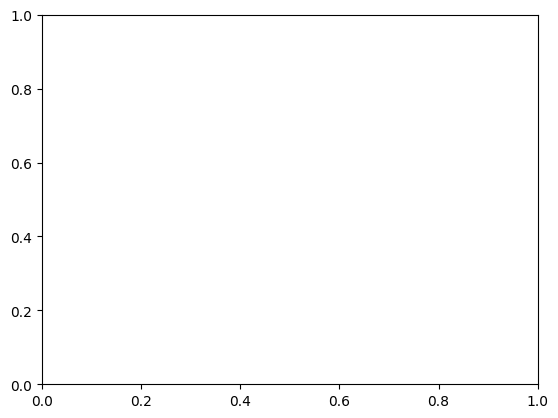

In [7]:
import matplotlib.pyplot as plt
plt.plot(train_loss_total_1,label ='train')
plt.plot(val_loss_total_1, label = 'val')
plt.title('train and val losses',fontsize =20, fontweight ='bold')
plt.xlabel('epochs')
plt.ylabel('losses')
plt.legend()
plt.show()

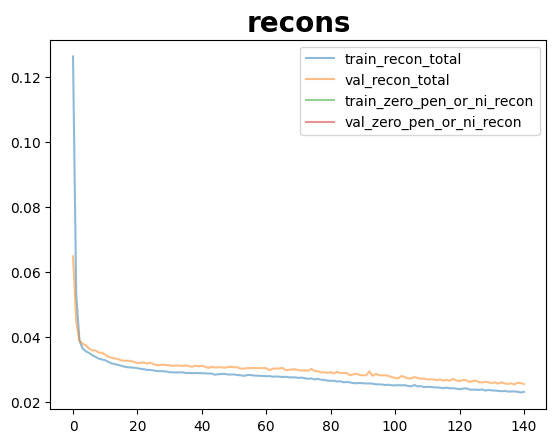

In [ ]:
plt.plot(train_recon_total,label='train_recon_total',alpha= 0.5)
plt.plot(val_recon_total,label='val_recon_total',alpha = 0.5)
plt.plot(train_zero_pen_or_ni_recon,label = 'train_zero_pen_or_ni_recon',alpha = 0.5)
plt.plot(val_zero_pen_or_ni_recon,label = 'val_zero_pen_or_ni_recon', alpha = 0.5)
plt.legend()
plt.title('recons',fontsize=  20,fontweight = 'bold')
plt.show()


### 훈련 초기 단계에서는 인코더가 훈련 데이터에 대한 의미있는 표현을 아직 학습하지 못했다.

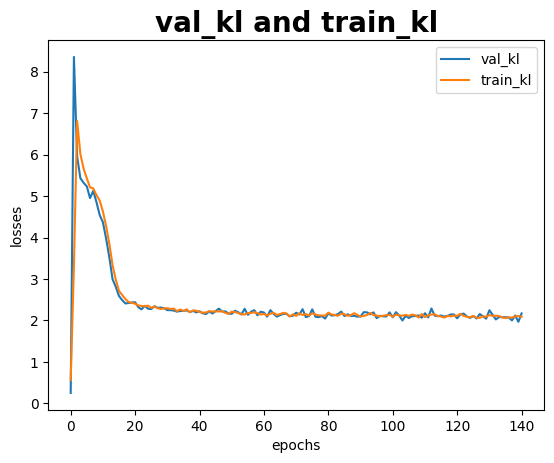

In [ ]:
plt.plot(val_kl,label = 'val_kl')
plt.plot(train_kl,label='train_kl')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('losses')
plt.title('val_kl and train_kl',fontsize = 20, fontweight = 'bold')
plt.show()

## metal_features에 대해서 각각의 r^2의 값에 대해서 생각

In [ ]:
model.load_state_dict(early.best_state)
model = model.to(device)
model.eval()

x_true_list = []
x_hat_list = []

with torch.no_grad():
    for x_test, c_test in test_loader:
        x_test = x_test.to(device)
        c_test = c_test.to(device)

        x_hat_test, test_mu, test_logvar = model(x_test, c_test)

        x_true_np = x_test.detach().cpu()
        x_hat_np = x_hat_test.detach().cpu()

        x_true_list.append(x_true_np)
        x_hat_list.append(x_hat_np)
        x_true = torch.cat(x_true_list,dim = 0)
        x_hat = torch.cat(x_hat_list,dim = 0)
        ss_res = torch.sum((x_true-x_hat)**2) ## 열로 해서 더한다.
        ss_tot = torch.sum((x_true-torch.mean(x_true))**2) 
        r2 = 1-ss_res/ss_tot
        print(r2.item())






0.8681756258010864
0.8442593812942505
0.8504430055618286
0.8478044271469116
0.8476448059082031
0.8457427024841309
0.8453643321990967
0.8456162214279175
0.8356316089630127
0.8393920660018921
0.8418339490890503
0.8480668067932129
0.8445974588394165
0.8443222045898438
0.8409935832023621
0.8412238359451294
0.843437671661377
0.8406821489334106
0.840579628944397


In [ ]:
x_true_flat = x_true.view(-1).numpy()
x_hat_flat  = x_hat.view(-1).numpy()


In [ ]:
x_true_flat.shape

(27186,)

In [ ]:
max(x_true_flat)

np.float32(3.4339871)

In [ ]:
r2.item()

0.840579628944397

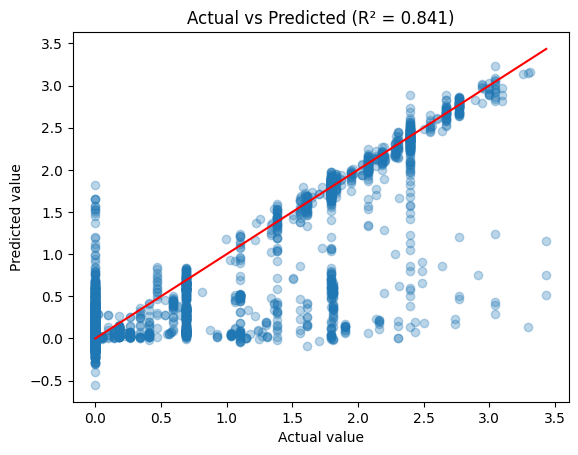

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(x_true_flat, x_hat_flat, alpha=0.3)
plt.plot(
    [x_true_flat.min(), x_true_flat.max()],
    [x_true_flat.min(), x_true_flat.max()], color = 'red'
)
plt.xlabel("Actual value")
plt.ylabel("Predicted value")
plt.title(f"Actual vs Predicted (R² = {r2.item():.3f})")
plt.show()


In [ ]:
x_true_test_np = np.concatenate(x_true_list, axis=0)
x_hat_test_np  = np.concatenate(x_hat_list, axis=0)
x_true_test = np.expm1(x_true_test_np)
x_hat_test = np.expm1(x_hat_test_np)

## r^2을 구하기 위해 전체 feature에 대해서 구한다
##

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score,root_mean_squared_error

rmse = np.sqrt(mean_squared_error(x_true_test, x_hat_test))
mse = mean_squared_error(x_true_test,x_hat_test)
r2 = r2_score(x_true_test.flatten(),x_hat_test.flatten())
print(f'rmse: {rmse:.4f},r2: {r2:.4f}')

rmse: 0.6879,r2: 0.8395


In [ ]:
# LOSS3에 대해서 3가지 따로 보기-> recon2,recon4,kl 모니터링용 
# CASE1과 CASE3의 DIVERGENCE LOSS을 따라가는지
# Nickel_weight=1, 나머지가 작아지는 추세로 ## 해결
# KL에 대해 그래프, VAL_KL,trian_kl다 출력 
# KL의 이유에 대해서 생각하기
# 1. 0을 clipping하는 방법(비 니켈에 대해서, 효과를 자제하기위해서는 출력하는 원소에 대해서, 전체에 대한 mse에 대해서 니켈에 대해서, 
# unique, 머신러닝내에서 최종적으로 softmax로 해서 제거하기)--> clipping: 3개가 넘게 예측을 하면 잘못된 규제를 한다. 
# 2.0초과하는 원소의 값 세가지( classification모델도 따로, cut_off로 진행, )


In [ ]:
## metal에 log(x+1)을 적용한다..

In [ ]:
## Ni 함량에 대해서 고민하기 
## Ni 피처의 유무 따져보기()

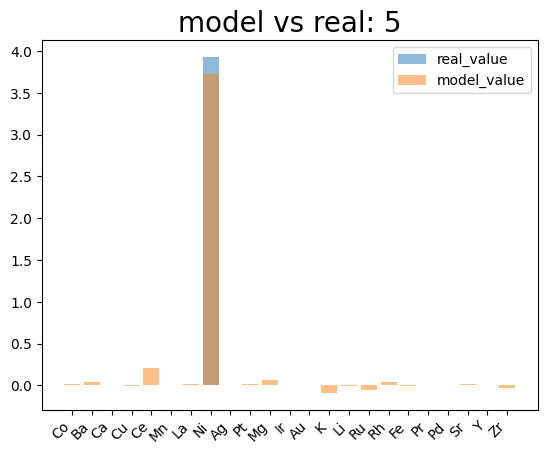

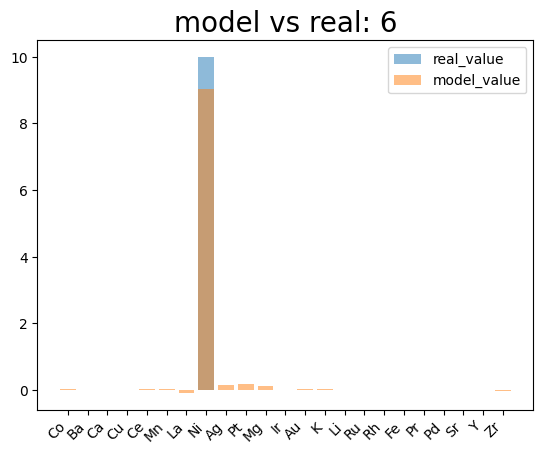

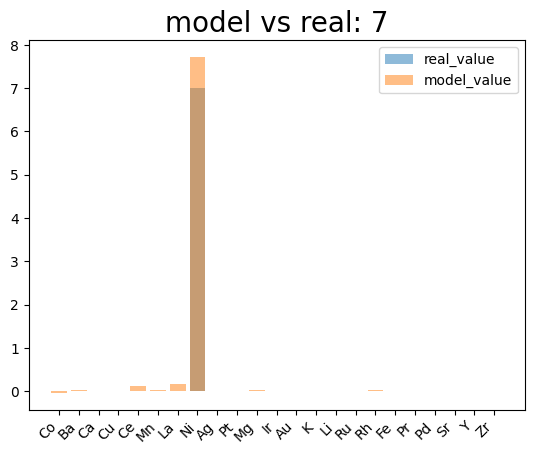

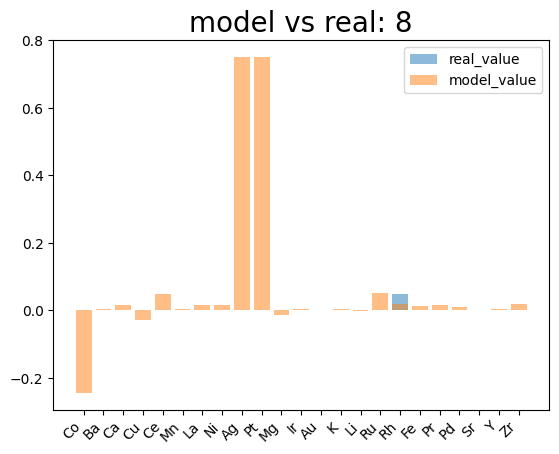

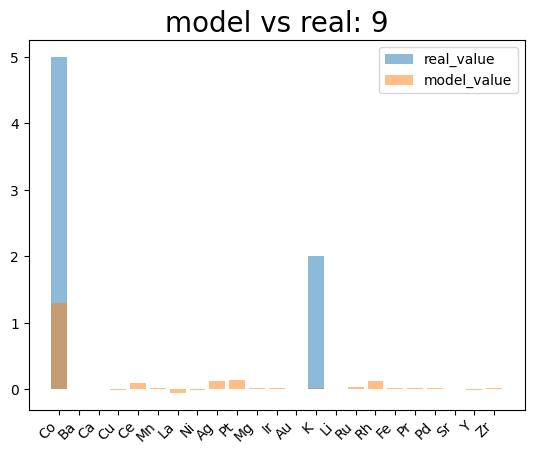

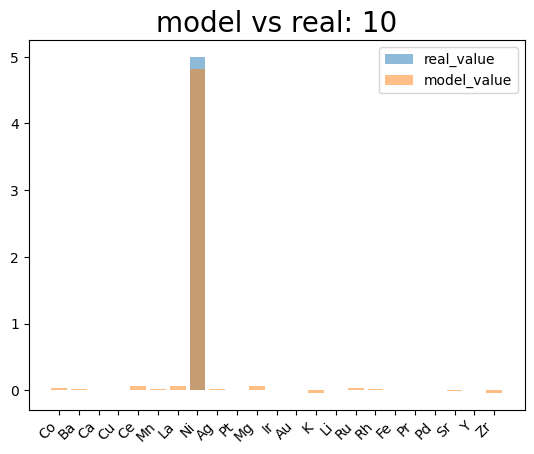

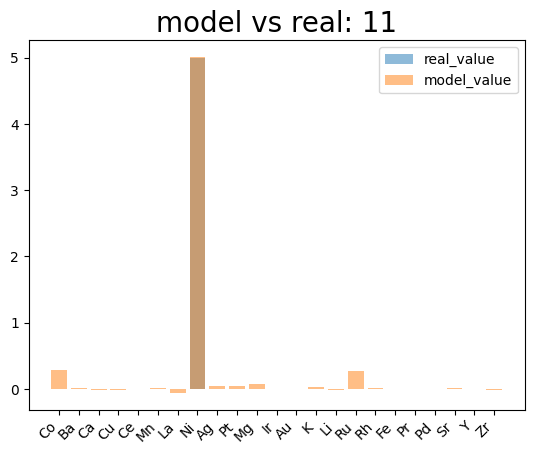

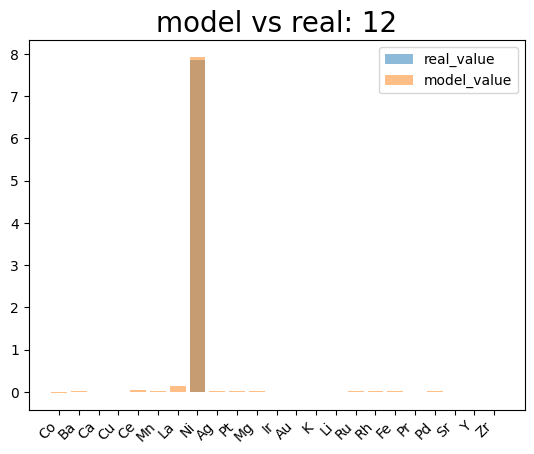

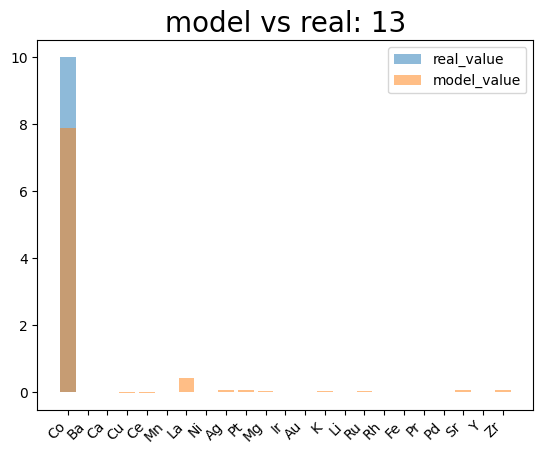

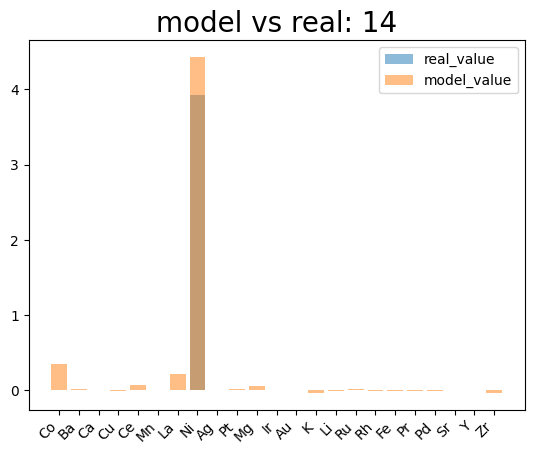

In [ ]:
df = pd.read_csv('211210-DRM-total.csv')
metal_columns = df.iloc[:,2:25].columns
for i in range(5,15):
    plt.bar(metal_columns, x_true_test[i],label = 'real_value',alpha = 0.5)
    plt.bar(metal_columns,x_hat_test[i],label = 'model_value', alpha=0.5)
    plt.xticks(rotation=45,ha='right')
    plt.title(f'model vs real: {i}',fontsize = 20)
    plt.legend()
    plt.show()